![Banner](./img/AI_Special_Program_Banner.jpg)

# Exercises for Ensemble Learning
---
The exercises are strongly oriented towards the lecture material and can often be solved with minor adaptations of the same.

## Data preparation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In this exercise we want to deal with glass: [Glass Identification Data Set](http://archive.ics.uci.edu/ml/datasets/Glass+Identification). This is about the classification of different types of glass based on the oxide compounds.

In [2]:
col_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Target']
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data', names=col_names)
df.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Target
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Remove the ID column (is only a surrogate key):

In [3]:
df.drop('Id', axis=1, inplace=True)

The data contains 7 different classes, which can be roughly divided into window glass and non-window glass. Since we want to consider a binary classification, we assign the superordinate categories accordingly:

In [4]:
map_target = {1 : 0, # building_windows_float_processed
              2 : 0, # building_windows_non_float_processed
              3 : 0, # vehicle_windows_float_processed
              4 : 0, # vehicle_windows_non_float_processed (none in this database)
              5 : 1, # containers
              6 : 1, # tableware
              7 : 1} # headlamps

In [5]:
df['Target'] = df['Target'].map(map_target)

Derive the feature matrix `X` and label vector `y`:

In [6]:
y = df.pop('Target')
X = df.copy()

Division of the data into training and test data. In addition, scaling of the data.

**Note:** We do this exactly in this order to avoid *data leakage*. You can find more information on this in this [article by Jason Brownlee](https://machinelearningmastery.com/data-leakage-machine-learning/) and this [blog post by Sebastian Raschka](https://sebastianraschka.com/faq/docs/scale-training-test.html).

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # sklearn.cross_validation has been superseded

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.25, 
                        stratify=y,
                        random_state=1)

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [8]:
print(f'There are {X_train_std.shape[0]} training data and {X_test_std.shape[0]} test data.')

There are 160 training data and 54 test data.


<h1 style="color:blue">Exercises</h1>

---

<h2 style="color:blue">Task 1 - Select the most important features</h2>

* Select the two most important features based on the `feature_importances_` of a decision tree
* Use the configuration below for the decision tree
* Which features have been selected?
* List all features and their feature importances. Which features do not contribute to the classification?
* Save the new feature matrices under `X_train_rel` and `X_test_rel` for further use

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(max_depth=3, 
                                criterion='gini', 
                                random_state=0)

In [10]:
# Your answer
clf_dt.fit(X_train, y_train)

clf_dt.feature_importances_

array([0.18325881, 0.05746668, 0.67371381, 0.01655588, 0.        ,
       0.        , 0.        , 0.06900482, 0.        ])

In [15]:
ser = pd.Series(clf_dt.feature_importances_, index=X.columns)

ser.sort_values(ascending=False)

Mg    0.673714
RI    0.183259
Ba    0.069005
Na    0.057467
Al    0.016556
Si    0.000000
K     0.000000
Ca    0.000000
Fe    0.000000
dtype: float64

In [16]:
X_train_rel = X_train[['Mg', 'RI']]
X_test_rel = X_test[['Mg', 'RI']]

<h2 style="color:blue">Task 2 - Create and cross-validate a voting classifier</h2>

1. Use the following base classifiers:
    1. *Perceptron*, with a maximum of 50 iterations, a tolerance of $10^{-3}$ and `random_state=0`
    2. [*Gaussian Naive Bayes*](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) with the default settings
    3. *Logistic regression* with the default settings (`random_state=0`)
2. Use Hard Voting
3. Since we are considering unevenly distributed classes here, you should use the [Balanced Accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score) and the F1 score as scoring criteria.

In [17]:
# Your answer
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

clf_mlp = MLPClassifier(hidden_layer_sizes=(50, 50),
                        activation='logistic',
                        solver='sgd',
                        alpha=0.001,
                        batch_size=50,
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        max_iter=50,
                        verbose=False, # set to True to follow live
                        random_state=0)

clf_gnb = GaussianNB()

clf_lr = LogisticRegression(penalty='l2',
                            solver='lbfgs',
                            C=0.1, 
                            random_state=0)


pipe_lr = Pipeline([['sc', StandardScaler()],
                   ['clf', clf_lr]])

clf_labels = ['Multi Layer Perceptron', 'GaussianNB', 'Logistic Regression']

print('10-fold cross validation:\n')
for clf, label in zip([clf_mlp, clf_gnb, pipe_lr], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc') 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.89 (+/- 0.10) [Multi Layer Perceptron]
ROC AUC: 0.96 (+/- 0.07) [GaussianNB]
ROC AUC: 0.96 (+/- 0.06) [Logistic Regression]


In [19]:
# Your answer
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

clf_mlp = MLPClassifier(hidden_layer_sizes=(50, 50),
                        activation='logistic',
                        solver='sgd',
                        alpha=0.001,
                        batch_size=50,
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        max_iter=50,
                        verbose=False, # set to True to follow live
                        random_state=0)

clf_gnb = GaussianNB()

clf_lr = LogisticRegression(penalty='l2',
                            solver='lbfgs',
                            C=0.1, 
                            random_state=0)


pipe_lr = Pipeline([['sc', StandardScaler()],
                   ['clf', clf_lr]])

clf_labels = ['Multi Layer Perceptron', 'GaussianNB', 'Logistic Regression']

print('10-fold cross validation:\n')
for clf, label in zip([clf_mlp, clf_gnb, pipe_lr], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train_rel, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc') 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.95 (+/- 0.08) [Multi Layer Perceptron]
ROC AUC: 0.94 (+/- 0.10) [GaussianNB]
ROC AUC: 0.96 (+/- 0.08) [Logistic Regression]


In [23]:
# Your answer
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

clf_mlp = MLPClassifier(hidden_layer_sizes=(50, 50),
                        activation='logistic',
                        solver='sgd',
                        alpha=0.001,
                        batch_size=50,
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        max_iter=50,
                        verbose=False, # set to True to follow live
                        random_state=0)

clf_gnb = GaussianNB()

clf_lr = LogisticRegression(penalty='l2',
                            solver='lbfgs',
                            C=0.1, 
                            random_state=0)


pipe_lr = Pipeline([['sc', StandardScaler()],
                   ['clf', clf_lr]])

clf_labels = ['Multi Layer Perceptron', 'GaussianNB', 'Logistic Regression']

print('10-fold cross validation:\n')
for clf, label in zip([clf_mlp, clf_gnb, pipe_lr], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train_rel, 
                             y=y_train, 
                             cv=10, 
                             scoring='accuracy') 
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

Accuracy: 0.76 (+/- 0.03) [Multi Layer Perceptron]
Accuracy: 0.88 (+/- 0.12) [GaussianNB]
Accuracy: 0.92 (+/- 0.09) [Logistic Regression]


In [28]:
# Majority Rule (soft) voting (no ROC/AUC available for hard voting)
from sklearn.ensemble import VotingClassifier
clf_mv = VotingClassifier(estimators=[('ppn',clf_mlp), ('gnb',clf_gnb), ('lr',pipe_lr)], voting='hard')

# note: proba is not available with hard voting, so in that case we would have to settle for accuracy instead of roc_auc

clf_labels += ['Majority Voting']
all_clf = [clf_mlp, clf_gnb, pipe_lr, clf_mv]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train_rel, 
                             y=y_train, 
                             cv=10, 
                             scoring='accuracy') # accuracy would be possible with hard voting
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

Accuracy: 0.76 (+/- 0.03) [Multi Layer Perceptron]
Accuracy: 0.88 (+/- 0.12) [GaussianNB]
Accuracy: 0.92 (+/- 0.09) [Logistic Regression]
Accuracy: 0.91 (+/- 0.09) [Majority Voting]


<h2 style="color:blue">Task 3 - Plot the decision areas of the ensemble and the base classifiers</h2>

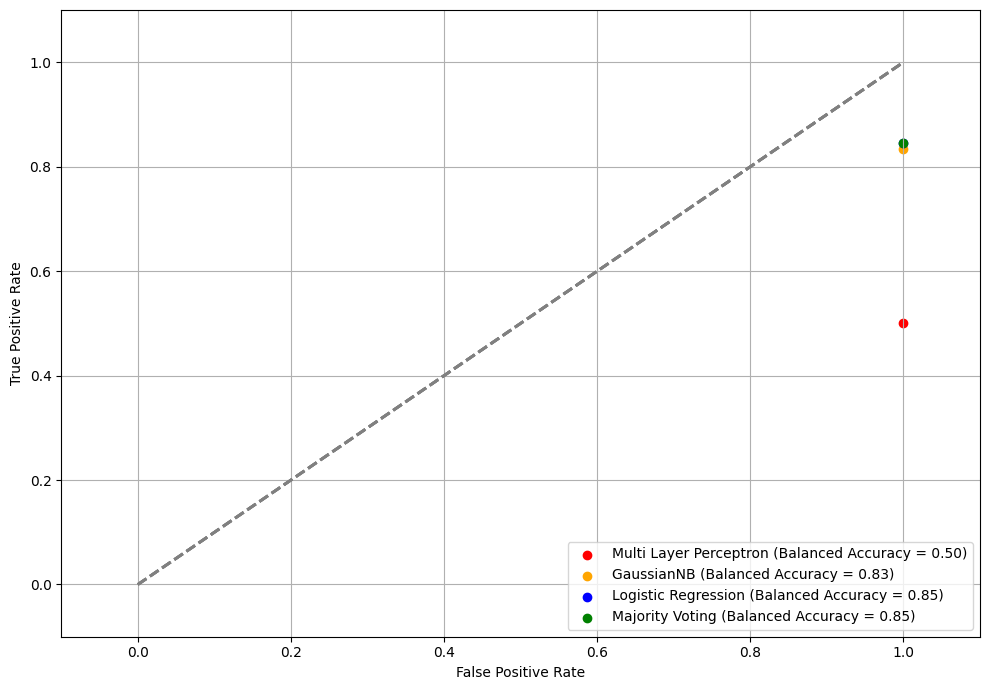

In [29]:
from sklearn.metrics import balanced_accuracy_score

plt.figure(figsize=(10, 7))
colors = ['red', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    y_pred = clf.fit(X_train_rel, y_train).predict(X_test_rel)

    # Use balanced accuracy instead of ROC AUC
    bal_accuracy = balanced_accuracy_score(y_test, y_pred)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2,)
    plt.scatter(1, bal_accuracy, color=clr, marker='o', label='%s (Balanced Accuracy = %0.2f)' % (label, bal_accuracy))

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/balanced_accuracy.png', dpi=300)
plt.show()

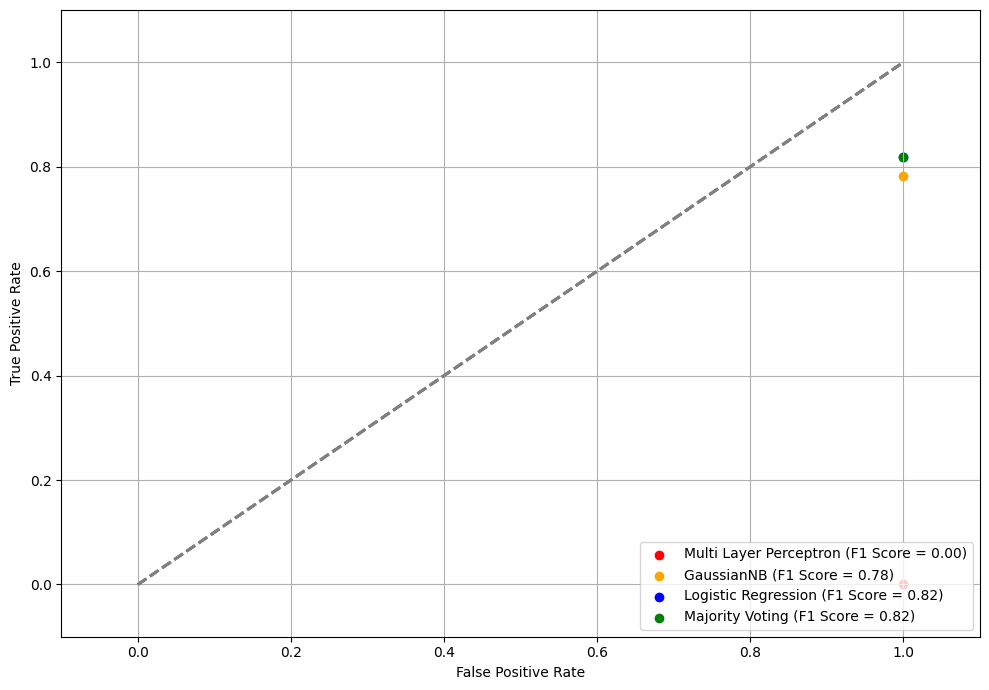

In [30]:
from sklearn.metrics import f1_score

plt.figure(figsize=(10, 7))
colors = ['red', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    y_pred = clf.fit(X_train_rel, y_train).predict(X_test_rel)

    # Use F1 score instead of ROC AUC
    f1 = f1_score(y_test, y_pred)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2,)
    plt.scatter(1, f1, color=clr, marker='o', label='%s (F1 Score = %0.2f)' % (label, f1))

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/f1_score.png', dpi=300)
plt.show()

<h2 style="color:blue">Task 4 - Check which parameters can be adjusted for the voting classifier</h2>

In [31]:
# Your answer
clf_mv.get_params()

{'estimators': [('ppn',
   MLPClassifier(activation='logistic', alpha=0.001, batch_size=50,
                 hidden_layer_sizes=(50, 50), max_iter=50, random_state=0,
                 solver='sgd')),
  ('gnb', GaussianNB()),
  ('lr',
   Pipeline(steps=[('sc', StandardScaler()),
                   ['clf', LogisticRegression(C=0.1, random_state=0)]]))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': None,
 'ppn': MLPClassifier(activation='logistic', alpha=0.001, batch_size=50,
               hidden_layer_sizes=(50, 50), max_iter=50, random_state=0,
               solver='sgd'),
 'gnb': GaussianNB(),
 'lr': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.1, random_state=0)]]),
 'ppn__activation': 'logistic',
 'ppn__alpha': 0.001,
 'ppn__batch_size': 50,
 'ppn__beta_1': 0.9,
 'ppn__beta_2': 0.999,
 'ppn__early_stopping': False,
 'ppn__epsilon': 1e-08,
 'ppn__hidden_layer_sizes': (50, 50),
 'ppn__learn

<h2 style="color:blue">Task 5 - Use Grid Search to investigate the effect of using class weights</h2>

* To do this, examine the `class_weight` parameter in the *perceptron* and the *logistic regression*
* Use the balanced accuracy as a metric

In [14]:
# Your answer
from sklearn.model_selection import GridSearchCV  # grid_search is now also part of model selection

params = {'ppn__class_weight': [1, 2],
          'lr__class_weight': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=clf_mv, 
                    param_grid=params, 
                    cv=10, 
                    scoring='balanced_accuracy')
grid.fit(X_train_std, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, std_score / 2, params))

<h2 style="color:blue">Task 6 - Train an Adaboost classifier with a perceptron as base classifier and a random forest and compare their respective accuracies (also with the base classifier)</h2>

* Use the *Balanced Accuracy* metric again
* Use the same settings for the perceptron as in task 2
* Since the perceptron does not provide class probabilities as output, you must set `algorithm='SAMME'` for Adaboost. Otherwise, use the same parameters as in the lecture material
* For the random forest, you can choose the same parameters as in the lecture materials

In [15]:
# Your answer

<h2 style="color:blue">Task 7 - Plot the decision regions of the classifiers just created</h2>

In [16]:
# Your answer